In [1]:
# Common
import os 
import keras
import numpy as np 
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2

ModuleNotFoundError: No module named 'keras'

In [2]:
# Class Names
root_path = '../input/car-vs-bike-classification-dataset/Car-Bike-Dataset/'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]


# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 2 
Class Names : ['Bike', 'Car']


Let's loot at the **Class Distribution**.

In [3]:
# Visualize 
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

**Great!!** the classes are **equally distributed**. This ensures that our **model cannot be biased** towards any class.

# **Data Loading**

It's time to **load the data**.

In [4]:
# Initialize Generator
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10, validation_split=0.1)

# Load Data
train_ds = train_gen.flow_from_directory(root_path, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32, subset='training')
valid_ds = train_gen.flow_from_directory(root_path, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32, subset='validation') 

Found 3600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# **Data Visualization**

The best way to understand the data is to **visualize it**.

In [5]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



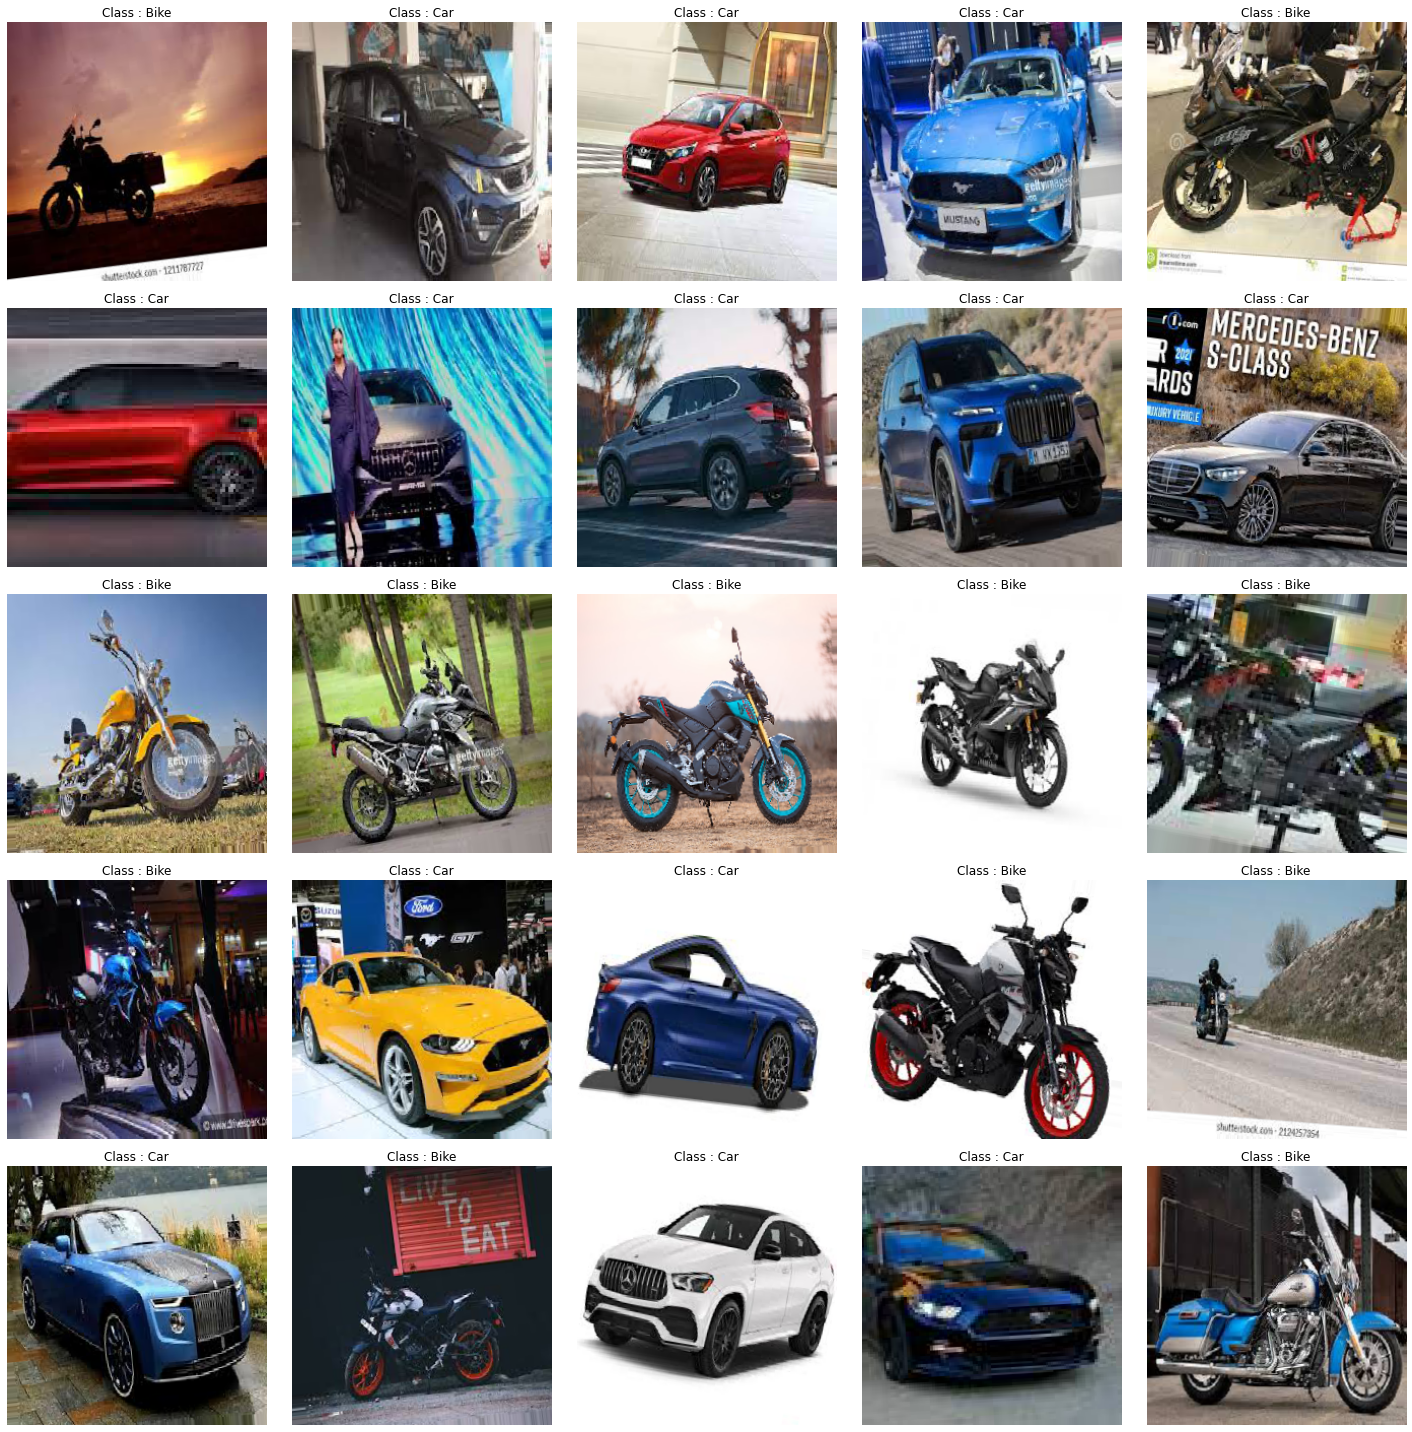

In [6]:
show_images()

This is going to be an **Interesting Task**. Let's see how **Transfer Learning** will perform.

# **Model**

In [7]:
# Pre-Trained Model 
base_model = ResNet50V2(input_shape=(256,256,3), include_top=False)
base_model.trainable = False

# Model Architecture
name = "ResNet50V2"
model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(n_classes, activation='softmax')
], name=name)

# Callbacks
cbs = [EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint(name + ".h5", save_best_only=True)]

# Model Compiling
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Training
history = model.fit(train_ds, validation_data=valid_ds, callbacks=cbs, epochs=50)

2022-10-28 09:15:25.363794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 09:15:25.367757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 09:15:25.368481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 09:15:25.370170: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 0s 0us/step


2022-10-28 09:15:30.729347: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-28 09:15:35.096640: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


113/113 [==============================] - 82s 640ms/step - loss: 0.0513 - accuracy: 0.9858 - val_loss: 0.0310 - val_accuracy: 0.9875


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/50
113/113 [==============================] - 66s 582ms/step - loss: 0.0271 - accuracy: 0.9931 - val_loss: 0.0076 - val_accuracy: 0.9950
Epoch 3/50
113/113 [==============================] - 65s 579ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 0.0215 - val_accuracy: 0.9900
Epoch 4/50
113/113 [==============================] - 65s 575ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.0160 - val_accuracy: 0.9900
Epoch 5/50
113/113 [==============================] - 65s 579ms/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.0216 - val_accuracy: 0.9900


The model **achieved 99%** accuracy in the second **Epoch** itself. The **best performance** of the model was achieved in the **4th Epoch** 
* **loss: 0.0038 - accuracy: 99.89% - val_loss: 0.0221 - val_accuracy: 99.25%**

---
Depending on the run, the performance of the model can change a little bit, but it will achieve an average **accuracy of 99%**.

In [8]:
data = pd.DataFrame(history.history)
data.head()

loss  accuracy  val_loss  val_accuracy
0  0.051309  0.985833  0.031005        0.9875
1  0.027125  0.993056  0.007607        0.9950
2  0.010691  0.996389  0.021518        0.9900
3  0.005952  0.998056  0.016008        0.9900
4  0.003212  0.998889  0.021617        0.9900

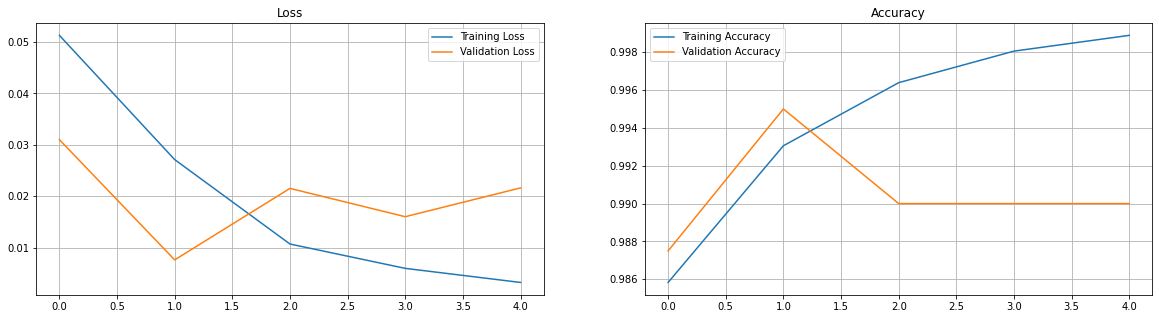

In [9]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(data.loss, label='Training Loss')
plt.plot(data.val_loss, label='Validation Loss')
plt.title("Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(data.accuracy, label='Training Accuracy')
plt.plot(data.val_accuracy, label='Validation Accuracy')
plt.title("Accuracy")
plt.grid()
plt.legend()

plt.show()

The **validation loss goes up**, and **validation accuracy goes down** for a **single epoch**. This could be because of the **weights adjustment**. It gets back **on track** from the **next epoch**.

# **Evaluation**

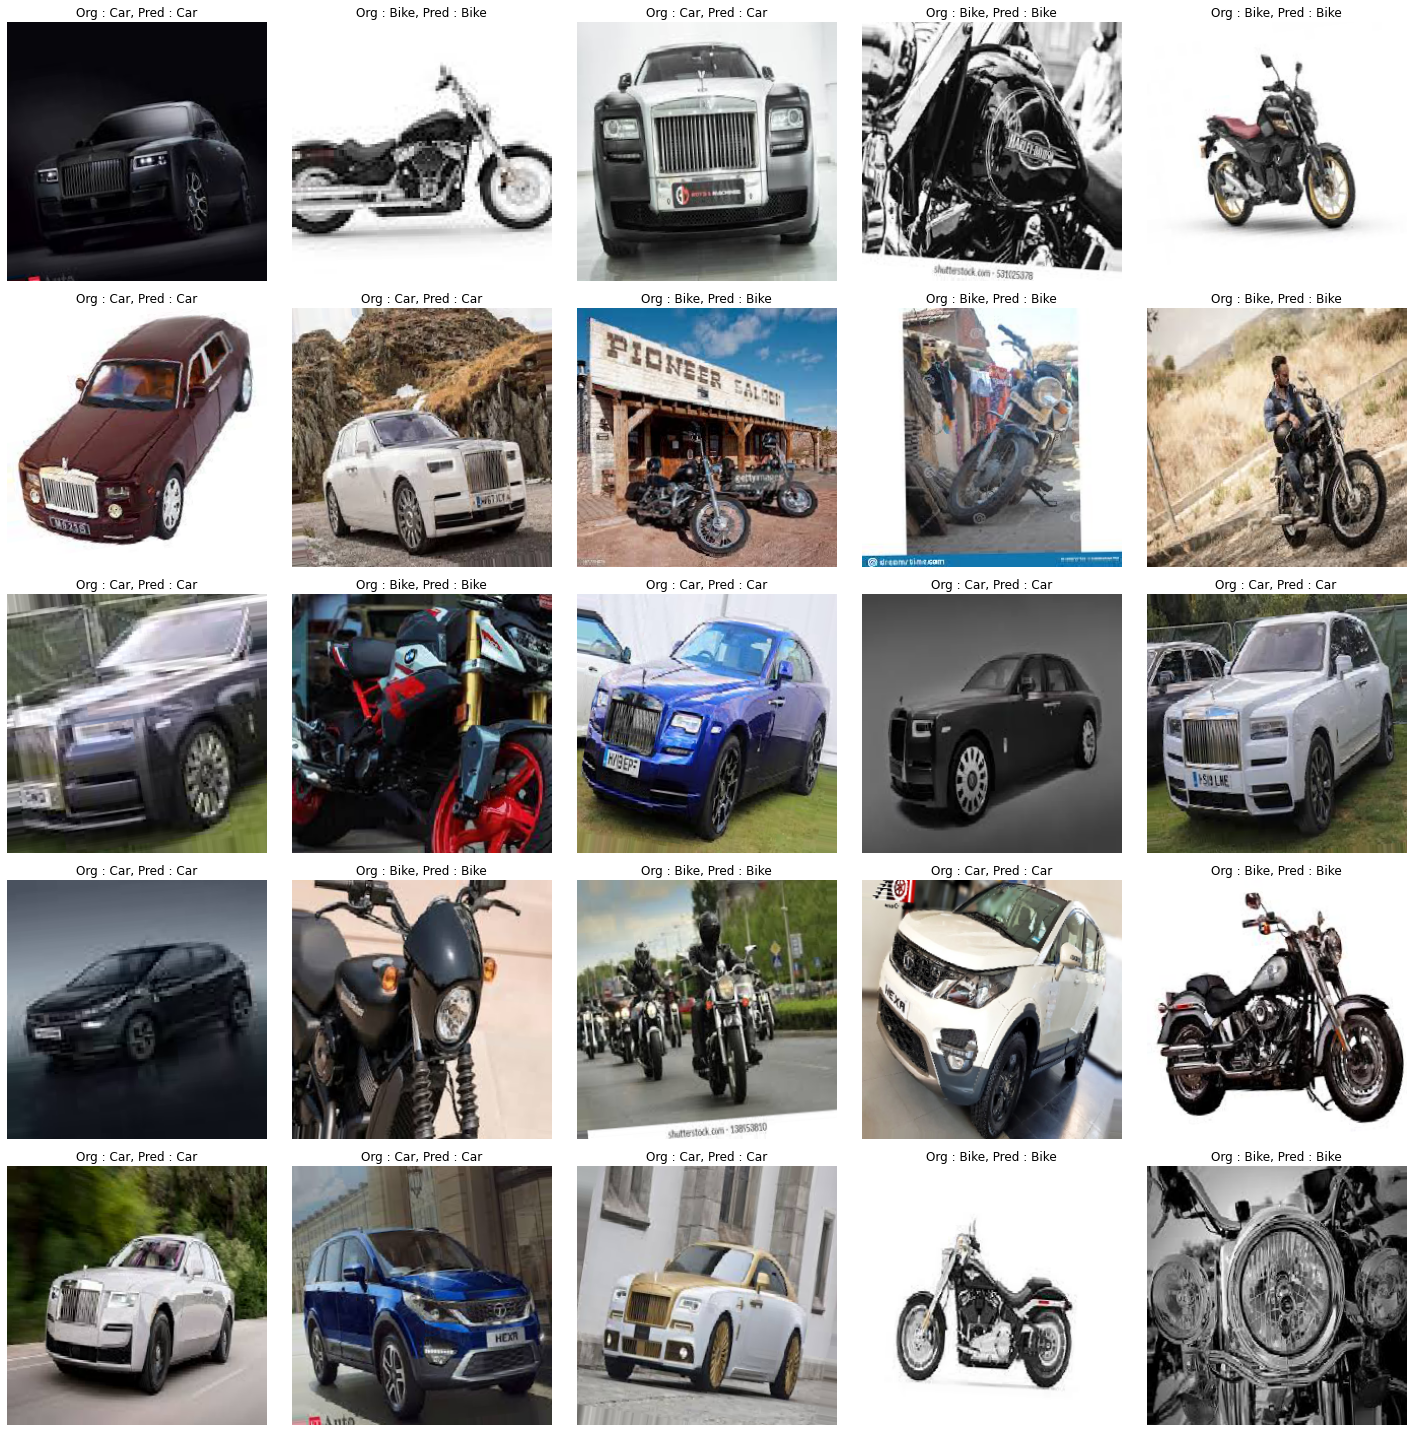

In [10]:
# Visualize Predictions
show_images(model=model, data=valid_ds)

All the **predictions are correct** as the model has **99% accuracy** on **training, testing and validation data set** it seems to be **very promising**. You can try the model.

**Thank You, Let me know your suggestions in the comment box.**

---
**DeepNets**